# UK energy data

From: https://www.gridwatch.templar.co.uk/download.php

> The CSV file and show the energy (MW, I believe) demand, generation (split by source) and import/export (split by country). The granularity is approximately 5 minute increments so we'll likely want to average to a timescale that matches our other data whilst being mindful of the fact that the timestamps are non-constant.

In [34]:
import pandas as pd
from matplotlib import pyplot as plt
import requests
import os
import numpy as np

In [35]:
# Go to repository root directory
if "_changed_dir" not in locals():
    os.chdir("../")
    _changed_dir = True

## Data download

In [36]:
raw_data_dir = 'data/raw'
if not os.path.exists(raw_data_dir):
    os.makedirs(raw_data_dir)

In [37]:

file_name = 'uk_energy_trends.csv'
# url = ".csv" NEED TO ADD THIS

file_path = os.path.join(raw_data_dir, file_name)

# myfile = requests.get(url) AND THIS
# open(file_path, 'wb').write(myfile.content) AND THIS

## Preprocess data

In [68]:
uk_energy = pd.read_csv(file_path)
new_names = {x:x if x[0]!=' ' else x[1:] for x in uk_energy.columns} # drop leading spaces
uk_energy.rename(columns = new_names, inplace=True)
uk_energy.drop(columns = ['id', 'frequency'], inplace=True) # drop useless columns
uk_energy.drop(columns = ['french_ict', 'dutch_ict', 'irish_ict',
                          'ew_ict', 'nemo'], inplace=True) # drop international import/export
uk_energy.drop(columns = ['north_south',
                          'scotland_england'], inplace=True) # drop intranational import/export
uk_energy["timestamp"] = pd.to_datetime(uk_energy["timestamp"])
uk_energy.set_index(["timestamp"], inplace=True)

In [70]:
uk_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13248 entries, 2020-05-01 00:00:35 to 2020-06-15 23:55:34
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   demand   13248 non-null  int64  
 1   coal     13248 non-null  int64  
 2   nuclear  13248 non-null  int64  
 3   ccgt     13248 non-null  int64  
 4   wind     13248 non-null  int64  
 5   pumped   13248 non-null  int64  
 6   hydro    13248 non-null  int64  
 7   biomass  13248 non-null  int64  
 8   oil      13248 non-null  int64  
 9   solar    13248 non-null  float64
 10  ocgt     13248 non-null  int64  
 11  other    13248 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 1.3 MB


In [71]:
uk_energy.head()

,demand,coal,nuclear,ccgt,wind,pumped,hydro,biomass,oil,solar,ocgt,other
timestamp,,,,,,,,,,,,
2020-05-01 00:00:35,20944,0,5789,5149,5461,0,181,1473,0,0.449,0,145
2020-05-01 00:05:34,20884,0,5784,5154,5406,0,181,1467,0,0.000,0,145
2020-05-01 00:10:34,21072,0,5781,5260,5373,98,181,1444,0,0.000,0,188
2020-05-01 00:15:34,21233,0,5785,5348,5396,142,181,1443,0,0.000,0,191
2020-05-01 00:20:35,21236,0,5788,5412,5441,51,181,1442,0,0.000,0,174


In [72]:
uk_energy.describe()

,demand,coal,nuclear,ccgt,wind,pumped,hydro,biomass,oil,solar,ocgt,other
count,13248.000000,13248.0,13248.000000,13248.000000,13248.000000,13248.000000,13248.000000,13248.000000,13248.0,13248.000000,13248.000000,13248.000000
mean,23102.325257,0.0,5202.566576,8062.540685,4213.961504,121.285402,282.555933,2274.609903,0.0,2272.977766,5.343297,148.896060
std,3196.348466,0.0,602.175348,3429.417909,2896.128859,263.894192,151.370378,738.834151,0.0,2664.781129,19.951365,49.476744
min,16596.000000,0.0,3798.000000,2609.000000,95.000000,0.000000,37.000000,321.000000,0.0,0.000000,0.000000,72.000000
25%,20412.750000,0.0,4714.000000,5197.750000,1631.500000,0.000000,166.000000,1751.000000,0.0,0.524000,0.000000,112.000000
50%,22805.500000,0.0,5264.500000,7490.000000,4044.000000,0.000000,249.500000,2421.000000,0.0,993.000000,0.000000,140.000000
75%,25549.000000,0.0,5753.000000,9981.000000,5919.000000,115.000000,377.000000,2977.000000,0.0,4230.000000,1.000000,170.000000
max,32464.000000,0.0,6222.000000,18952.000000,11608.000000,2127.000000,939.000000,3122.000000,0.0,9240.000000,125.000000,367.000000


In [73]:
uk_energy.isnull().values.any()

False

In [76]:
print(f"Data in range: {uk_energy.index.min()} to {uk_energy.index.max()}")

Data in range: 2020-05-01 00:00:35 to 2020-06-15 23:55:34


## Plotting data

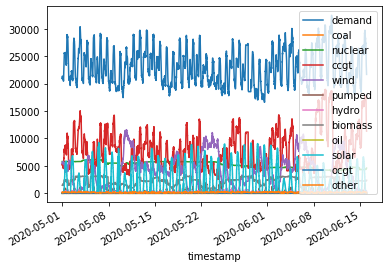

In [77]:
uk_energy.plot()

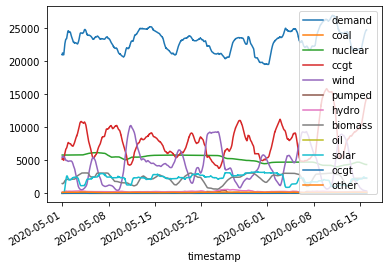

In [81]:
uk_energy.rolling('1D').mean().plot()

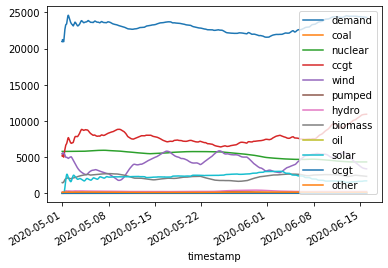

In [82]:
uk_energy.rolling('7D').mean().plot()